# TabuLa

Run on half of the data (150K rows) for 20 epochs took 7 hours

In [1]:
!git clone https://github.com/zhao-zilong/Tabula.git

Cloning into 'Tabula'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 39 (delta 18), reused 32 (delta 11), pack-reused 0
Receiving objects: 100% (39/39), 45.99 KiB | 523.00 KiB/s, done.
Resolving deltas: 100% (18/18), done.


In [1]:
import sys
sys.path.append('Tabula')

## Get MOOC data

In [2]:
!wget -q https://huggingface.co/datasets/sswt/stanford-act-mooc/resolve/main/act-mooc.csv.gz

In [2]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

In [3]:
df = pd.read_csv('act-mooc.csv.gz')
del df['ACTIONID']
df = df.drop_duplicates()
print(df.shape)

(396712, 8)


In [4]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_ix, test_ix = next(gss.split(df, groups=df['USERID']))
df_train = df.iloc[train_ix].copy()
df_test = df.iloc[test_ix].copy()
df_train.shape, df_test.shape

((271341, 8), (125371, 8))

In [5]:
df_train.to_csv('act-mooc-train.csv.gz', index=False)
df_test.to_csv('act-mooc-test.csv.gz', index=False)

## Download pretrained tabular model

In [14]:
!mkdir pretrained-tabula

In [25]:
!wget "https://drive.usercontent.google.com/download?id=1BJ9shdCzOyMaXClB8oSIzyfjdjvjP8b-&confirm=xxx" -O pretrained-tabula/model.pt

--2024-01-23 19:18:38--  https://drive.usercontent.google.com/download?id=1BJ9shdCzOyMaXClB8oSIzyfjdjvjP8b-&confirm=xxx
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.205.132, 2a00:1450:4010:c0f::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.205.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327681025 (313M) [application/octet-stream]
Saving to: ‘pretrained-tabula/model.pt’

pretrained-tabula/m 100%[===================>] 312.50M  84.3MB/s    in 3.9s    

2024-01-23 19:18:43 (79.3 MB/s) - ‘pretrained-tabula/model.pt’ saved [327681025/327681025]



## Run Training

In [6]:
# change tabula to tabula_middle_padding to test middle padding method
from tabula import Tabula

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
categorical_columns = ["USERID", "TARGETID", "LABEL"]
num_epochs = 20  # 400
model = Tabula(llm='distilgpt2', experiment_dir="tabule", batch_size=32, epochs=num_epochs, categorical_columns=categorical_columns)

In [8]:
# Comment this block out to test tabula starting from randomly initialized model.
# Comment this block out when uses tabula_middle_padding
import torch
model.model.load_state_dict(torch.load("pretrained-tabula/model.pt"), strict=False)

<All keys matched successfully>

In [9]:
model.fit(df_train.head(150000).copy())

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,1.089400
1000,0.600500
1500,0.584000
2000,0.563500
2500,0.552500
3000,0.545100
3500,0.540600
4000,0.535900
4500,0.531500
5000,0.525700


In [10]:
import torch
torch.save(model.model.state_dict(), "pretrained-tabula/model_20epoch.pt")

import torch
model.model.load_state_dict(torch.load("pretrained-tabula/model_10epoch.pt"), strict=False)

## Sample

In [14]:
n = 100
n = df_train.shape[0]
df_syn = model.sample(n_samples=n)

271364it [55:02, 82.16it/s]                            
/app/notebooks/Tabula/tabula/tabula.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[self.label_encoder_list[i]['column']] = pd.to_numeric(data[self.label_encoder_list[i]['column']], errors='coerce')


In [15]:
df_syn.head()

,USERID,TARGETID,TIMESTAMP,FEATURE0,FEATURE1,FEATURE2,FEATURE3,LABEL
0,4448,34,868204.0,-0.319991,2.108722,-0.394237,-0.067309,1
1,56,8,626605.0,-0.319991,-0.435701,0.106784,-0.067309,0
2,4088,33,1156466.0,-0.319991,-0.435701,0.607805,3.745915,0
3,2766,51,1476171.0,1.028091,-0.435701,-0.394237,-0.067309,0
4,4166,3,710879.0,-0.319991,-0.435701,0.106784,-0.067309,0


In [16]:
df_syn.to_csv("data/tabula_20ep_150K.csv.gz", index=False)

In [28]:
df_syn = df_syn.astype(df_train.dtypes)

## Evaluate

In [24]:
import matplotlib.pyplot as plt

In [29]:
df_syn['LABEL'].value_counts()

LABEL
0    268194
1      3120
Name: count, dtype: int64

In [19]:
df_syn.TIMESTAMP.describe()

count    2.713140e+05
mean     4.521219e+07
std      2.309195e+10
min      6.000000e+00
25%      5.455850e+05
50%      8.931535e+05
75%      1.235146e+06
max      1.202809e+13
Name: TIMESTAMP, dtype: float64

In [20]:
df_train.TIMESTAMP.describe()

count    2.713410e+05
mean     1.387566e+06
std      7.402533e+05
min      0.000000e+00
25%      7.870880e+05
50%      1.460944e+06
75%      2.013916e+06
max      2.572086e+06
Name: TIMESTAMP, dtype: float64

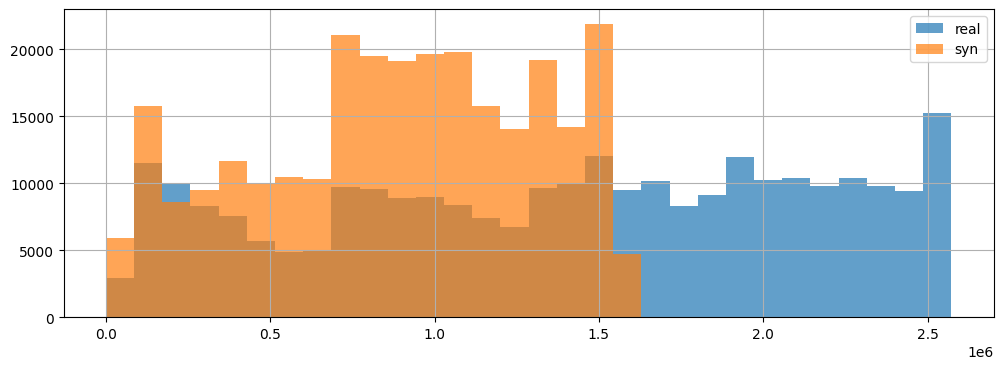

In [25]:
df_train['TIMESTAMP'].hist(figsize=(12, 4), alpha=.7, bins=30)
df_syn['TIMESTAMP'].clip(upper=df_train['TIMESTAMP'].max()).hist(alpha=.7, bins=30)
plt.legend(['real', 'syn'])

In [30]:
col = 'LABEL'
pd.concat([
    df_train[col].value_counts().rename('Real'),
    df_syn[col].value_counts().rename('Syn'),
], axis=1)

,Real,Syn
LABEL,,
0,268474,268194
1,2867,3120


In [31]:
for col in ['USERID', 'TARGETID']:
    print(f'{col}: real - {df_train[col].nunique()}, {df_syn[col].nunique()}')

USERID: real - 4932, 4193
TARGETID: real - 97, 56


### TSTR

In [32]:
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

def get_features(df):
    agg_dict = {
        'LABEL': ('LABEL', 'max'),
        'cnt': ('LABEL', 'count'),
        'min_ts': ('TIMESTAMP', 'min'),
        'max_ts': ('TIMESTAMP', 'max')
    }
    agg_dict.update({f'mean_{c}': (c, 'mean')
                    for c in ['FEATURE0', 'FEATURE1', 'FEATURE2', 'FEATURE3']})
    agg_dict.update({f'max_{c}': (c, 'max')
                    for c in ['FEATURE0', 'FEATURE1', 'FEATURE2', 'FEATURE3']})
    df_agg = df.groupby('USERID').agg(**agg_dict).reset_index()
    df_agg['dur'] = df_agg['max_ts'] - df_agg['min_ts']
    del df_agg['max_ts'], df_agg['min_ts']
    return df_agg

In [33]:
df_train_feat = get_features(df_train)
df_test_feat = get_features(df_test)
df_syn_feat = get_features(df_syn)
df_train_feat.shape, df_test_feat.shape, df_syn_feat.shape

((4932, 12), (2115, 12), (4193, 12))

In [34]:
df_syn_feat = df_syn_feat.astype(df_train_feat.dtypes)

In [35]:
def eval_model(df_train, df_test, mode):
    X_train = df_train.copy()
    y_train = X_train.pop('LABEL')
    X_test = df_test.copy()
    y_test = X_test.pop('LABEL')
    xgb = XGBClassifier(n_estimators=30, max_depth=5, learning_rate=.1, objective='binary:logistic', verbosity=1)
    xgb.fit(X_train, y_train)
    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)
    metrics = {'mode': mode,
               'cnt_rows_train': y_train.shape[0],
               'cnt_ones_train': (y_train == 1).sum(),
               'F1_train': f1_score(y_train, y_pred_train),
               'F1_test': f1_score(y_test, y_pred_test)}
    return metrics

In [36]:
df_eval = pd.DataFrame([
    eval_model(df_syn_feat, df_test_feat, 'TSTR'),
    eval_model(df_train_feat, df_test_feat, 'TRTR')
])
df_eval

,mode,cnt_rows_train,cnt_ones_train,F1_train,F1_test
0,TSTR,4193,1803,0.686200,0.236967
1,TRTR,4932,2867,0.866609,0.827356
